In [11]:
#!pip install windrose

In [308]:
import requests
import json
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import MousePosition
import matplotlib.pyplot as plt
import numpy as np
import datetime
from ipywidgets import interact
import ipywidgets as widgets
from math import sin, cos, sqrt, atan2, radians
from dateutil import parser
from datetime import datetime

In [13]:
# Map of France
frmap = folium.Map(
    location=[47,4],
    tiles='cartodbpositron',
    zoom_start=6,
    control_scale=True
)
MousePosition().add_to(frmap)

In [14]:
# Convert degrees to cardinal direction
def degree_to_cardinal(theta):
    if  11.25>=theta>=348.75:
        return 'N'
    elif 11.25<theta<= 33.75:
        return 'NNE'
    elif 33.75 <theta<= 56.25:
        return 'NE'
    elif 56.25 <theta<= 78.75:
        return 'ENE'
    elif 78.75 <theta<= 101.25:
        return 'E'
    elif 101.25 <theta<= 123.75:
        return 'ESE'
    elif 123.75 <theta<= 146.25:
        return 'SE'
    elif 146.25 <theta<= 168.75:
        return 'SSE'
    elif 168.75 <theta<= 191.25:
        return 'S'
    elif 191.25 <theta<= 213.75:
        return 'SSW'
    elif 213.75 <theta<= 236.25:
        return 'SW'
    elif 236.25 <theta<= 258.75:
        return 'WSW'
    elif 258.75 <theta<= 281.25:
        return 'W'
    elif 281.25 <theta<= 303.75:
        return 'WNW'
    elif 303.75  <theta<= 326.25:
        return 'NW'
    elif 326.25 <theta<= 348.75:
        return 'NNW'

In [24]:
# calculate earth radius for a given latitude: https://www.mathworks.com/help/aeroblks/radiusatgeocentriclatitude.html
def get_radius(lat,elevation):
    re= 6378137 #m radius at the equator
    f=1/298.257223563 #Earth flattening
    r=re/(1+(1/(1-f)**2-1)*sin(lat)**2)+elevation # TODO: wrong elevation bc of geometry but mb there is a method
    return r

In [376]:
# This is a quick and dirty conversion, should use proper projections
# dist is in m
def get_degree(dist, lat, elevation):
    degr=dist*360/(np.pi*2*get_radius(lat, elevation))
    return degr
step_size=get_degree(2300,43.6184, 216) # a very small number for 10 m => the API resolution is ~2.5km?

43.597721809849425 43.65975638
[43.59772181 43.6184     43.63907819]
Lattice centroids:


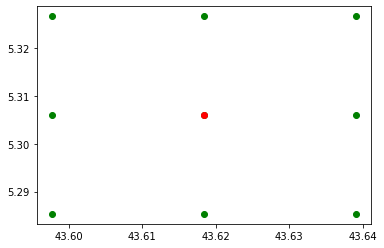

In [377]:
lat, lon = 43.6184, 5.306
n_coord = 1
minlat, maxlat = lat-step_size*n_coord, round(lat+step_size*(n_coord+1),8)
minlon, maxlon = lon-step_size*n_coord, round(lon+step_size*(n_coord+1),8)
print(minlat, maxlat)
lats = np.arange(minlat, maxlat, step_size)
lons = np.arange(minlon, maxlon, step_size)
print(lats)
coordinates = np.array([[x, y] for x in lats for y in lons])
print("Lattice centroids:")
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='g')
plt.scatter(lat, lon, color='r')
plt.show()

In [378]:
l,m=[],[]
for i in coordinates:
    l.append(i[0])
    m.append(i[1])
locdf = pd.DataFrame({"latitude": l, "longitude": m}).reset_index()
locdf.head()

,index,latitude,longitude
0,0,43.597722,5.285322
1,1,43.597722,5.306000
2,2,43.597722,5.326678
3,3,43.618400,5.285322
4,4,43.618400,5.306000


In [379]:
# Get a 7 day hourly prediction
# Here we get temperature and relative humidity within 2m, precipitation, wind speed and wind direction within 10 m
frames=[]
for i, row in locdf.iterrows():
    url="https://api.open-meteo.com/v1/forecast?latitude="+str(row["latitude"])+"&longitude="+str(row["longitude"])+"&hourly=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m,winddirection_10m"
    x = requests.get(url)
    y = json.loads(x.text)
    x.close()
    # to make place-time series:
    df = pd.json_normalize(y, sep='_')
    df['hourly_time'] =[[parser.parse(d) for d in df["hourly_time"][0]]]
    frames.append(df)
dff=pd.concat(frames)

In [380]:
dff.head()

,generationtime_ms,elevation,latitude,utc_offset_seconds,longitude,hourly_winddirection_10m,hourly_precipitation,hourly_windspeed_10m,hourly_temperature_2m,hourly_relativehumidity_2m,hourly_time,hourly_units_winddirection_10m,hourly_units_windspeed_10m,hourly_units_precipitation,hourly_units_temperature_2m,hourly_units_relativehumidity_2m,hourly_units_time
0,1.698971,195.875,43.60,0,5.28,"[94, 89, 98, 88, 86, 96, 92, 71, 342, 4, 197, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.2, 5, 5.1, 5.4, 5.8, 5.6, 5, 2.1, 1.9, 0.5,...","[17.3, 17.2, 16.8, 16.6, 16.6, 18, 20.3, 22.8,...","[76, 75, 76, 76, 76, 69, 61, 52, 43, 35, 31, 3...","[2022-06-02 00:00:00, 2022-06-02 01:00:00, 202...",°,km/h,mm,°C,%,iso8601
0,1.757026,209.625,43.60,0,5.30,"[94, 88, 91, 88, 86, 90, 90, 78, 30, 76, 158, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5.8, 5.7, 6, 6, 6.6, 6.8, 5.9, 3.3, 2, 1.4, 2...","[17.7, 17.6, 17.1, 16.9, 16.8, 18.1, 20.2, 22....","[74, 73, 75, 75, 76, 69, 62, 53, 43, 34, 30, 3...","[2022-06-02 00:00:00, 2022-06-02 01:00:00, 202...",°,km/h,mm,°C,%,iso8601
0,1.775980,232.000,43.60,0,5.32,"[90, 84, 86, 84, 83, 86, 86, 74, 48, 75, 153, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.1, 6.1, 6.5, 6.3, 6.9, 7.4, 6.2, 3.6, 2.4, ...","[17.7, 17.6, 17.2, 16.7, 16.6, 17.6, 19.7, 22....","[73, 73, 75, 77, 77, 72, 65, 55, 44, 35, 31, 3...","[2022-06-02 00:00:00, 2022-06-02 01:00:00, 202...",°,km/h,mm,°C,%,iso8601
0,1.788020,187.375,43.62,0,5.28,"[91, 83, 78, 86, 80, 77, 85, 79, 22, 92, 140, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 6, 6.4, 6.3, 7, 7.3, 6.1, 3.7, 2.2, 1.8, 3...","[17.7, 17.6, 17.1, 16.9, 16.7, 17.9, 20.4, 22....","[74, 73, 74, 75, 76, 70, 61, 52, 43, 34, 29, 2...","[2022-06-02 00:00:00, 2022-06-02 01:00:00, 202...",°,km/h,mm,°C,%,iso8601
0,1.739025,216.750,43.62,0,5.30,"[95, 88, 86, 89, 85, 84, 88, 81, 42, 90, 136, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.5, 6.7, 7.5, 6.9, 7.6, 8.3, 6.7, 4.3, 2.5, ...","[17.8, 17.6, 17.1, 16.7, 16.5, 17.6, 20, 22.5,...","[74, 72, 74, 76, 77, 71, 63, 53, 44, 34, 30, 3...","[2022-06-02 00:00:00, 2022-06-02 01:00:00, 202...",°,km/h,mm,°C,%,iso8601


In [405]:
# get current hours conditions:
now=datetime.now().time()
idx=0
for i, val in enumerate(df.iloc[0]["hourly_time"][0:24]):
    if now.hour==val.hour:
        idx=i

In [404]:
# interactive plots
def f(x):
    plt.plot(np.arange(0,24,1),hourly[str(x)][0][0:24])
    plt.plot(now.hour,hourly[str(x)][0][idx], 'or')
    plt.xlabel('Hours', fontsize=16)
    if 'temperature' in x:
        plt.ylabel('°C',fontsize=16)
    elif 'windspeed' in x:
        plt.ylabel('km/h',fontsize=16)
    elif 'relativehumidity' in x:
        plt.ylabel('%',fontsize=16)
    elif 'winddirection' in x:
        plt.ylabel('°',fontsize=16)
    else:
        plt.ylabel('mm',fontsize=16)

hourly=df[['hourly_temperature_2m','hourly_relativehumidity_2m','hourly_windspeed_10m','hourly_precipitation','hourly_winddirection_10m']]

interact(f,x=hourly)

interactive(children=(Dropdown(description='x', options=('hourly_temperature_2m', 'hourly_relativehumidity_2m'…

<function __main__.f(x)>

In [406]:
# Display on map
# TODO: convert time and display current data not the first

text = ' '.join(['Temperature:', str(hourly['hourly_temperature_2m'][0][idx]), '°C<br> Wind direction:',
                 str(degree_to_cardinal(hourly['hourly_winddirection_10m'][0][idx])),
                 '<br> Wind speed :',str(hourly['hourly_windspeed_10m'][0][idx]),'km/h <br> Relative humidity:',
                str(hourly['hourly_relativehumidity_2m'][0][idx]),'%<br> Elevation:',str(df['elevation'][0]), 'm'])

iframe = folium.IFrame(text,
                       width=300,
                       height=120)

popup = folium.Popup(iframe,
                     max_width=300)

marker = folium.Marker([44.6184747,4.3061143],icon=folium.Icon(color='red', icon='fire', prefix='glyphicon'),
                       popup=popup).add_to(frmap)
frmap